In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")   ##### ignore warnings 

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
#read data
ts_data = pd.read_csv('./data/1-retail_daily_amount.csv', index_col='Date', parse_dates=True)
log_data = pd.read_csv('./data/2-retail_daily_amount_log.csv', index_col='Date', parse_dates=True)
log_data_r_mean = pd.read_csv('./data/2-retail_daily_amount_log_r_mean.csv', index_col='Date', parse_dates=True)
log_returns = pd.read_csv('./data/2-retail_daily_amount_log_returns.csv', index_col='Date', parse_dates=True)
df_diff = pd.read_csv('./data/2-retail_daily_amount_diff.csv', index_col='Date', parse_dates=True)

In [3]:
# fix seed to make sure it is reproducible
np.random.seed(123)

# Rebuild SARIMA model

The ARCH/GARCH models will run over the based SARIMA(2,0,0)(2,1,1)[12] model with smoothed data (log_data_r_mean) from the "3-Model_ARMA_ARIMA_SARIMA" notebook, as it found the best performance between our tests

In [10]:
data=np.exp(log_data_r_mean)

In [11]:
# Create Training and Test
data=data['Amount']

train_data = data[:417]
test_data = data[417:]

In [12]:
# Let's fit this model
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = SARIMAX(train_data,order=(2,0,0),seasonal_order=(2,1,1,12))

results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               Amount   No. Observations:                  417
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood               -3906.813
Date:                              Sat, 19 Jun 2021   AIC                           7825.626
Time:                                      10:52:13   BIC                           7849.650
Sample:                                           0   HQIC                          7835.135
                                              - 417                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2256      0.038     32.579      0.000       1.152       1.299
ar.L2         -0.2974      0.040     -7.464      0.000      -0.375      -0.219
ar.S.L12       0.0018      0.070      0.026      0.979      -0.136       0.140
ar.S.L24       0.1665      0.060      2.766      0.006       0.049       0.284
ma.S.L12      -0.7970      0.060    -13.297      0.000      -0.915      -0.680
sigma2      1.361e+07   2.26e-09   6.02e+15      0.000    1.36e+07    1.36e+07
===================================================================================
Ljung-Box (Q):                       89.77   Jarque-Bera (JB):               638.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.69
Prob(H) (two-sided):                  0.07   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.73e+31. Standard errors may be unstable.
"""

# ARCH Models

## ARCH-LM Test on the SARIMA residuals

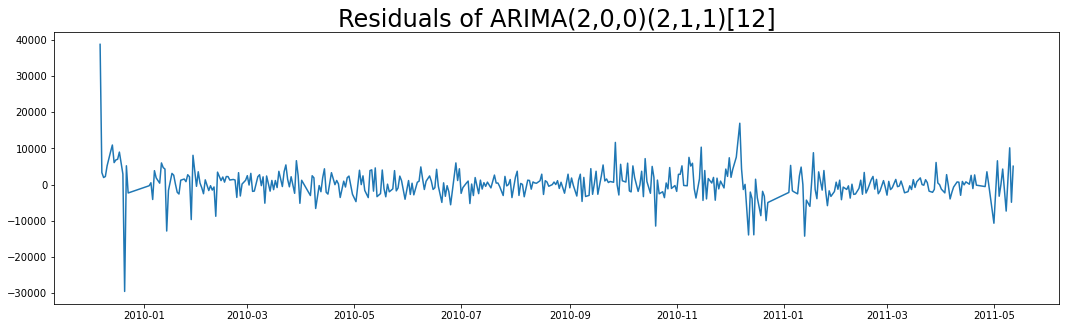

In [14]:
# Set the figure size
plt.rcParams["figure.figsize"] = 18, 5
# Plotting residuals
plt.plot(results.resid, label = "Residuals")
# Setting Title
plt.title("Residuals of ARIMA(2,0,0)(2,1,1)[12]", size = 24)
# Display the plot
plt.show()

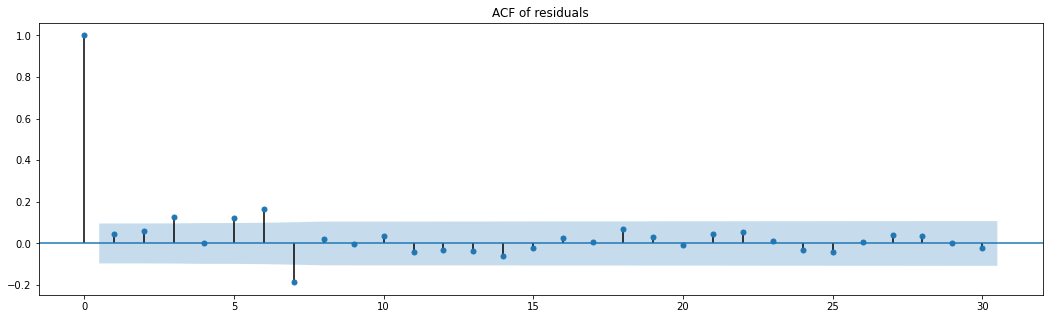

In [23]:
plot_acf(results.resid, lags=30, alpha=0.05, title="ACF of residuals")
plt.show()

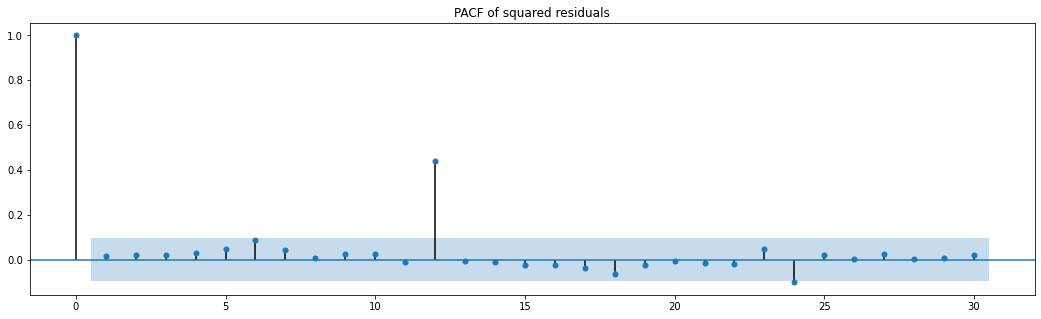

In [24]:
plot_pacf(results.resid**2, lags=30, alpha=0.05, title="PACF of squared residuals")
plt.show()

Now we will apply the LM-ARCH test in order to identify Heteroskedasticity on residuals

In [16]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(results.resid, maxlag=50)

print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')

Lagrange mulitplier p-value: 8.434589069612125e-05
F test p-value: 1.2954025422680183e-05


Both p-value are smaller than 0.05 we reject the null hypothesis that residuals are white noise, it points to heteroskedasticity. So we will check the ARCH and GARCH modelos

## ARCH model